<a href="https://colab.research.google.com/github/arya-snh/CSE508_Winter2024_A3_2020498/blob/main/IR_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import gzip
import json

import re
import unicodedata
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from math import sqrt

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# review_df = pd.read_pickle('review_df.pickle')
metadata_df = pd.read_pickle('/content/drive/MyDrive/IR/A3/headphones_metadata_df.pickle')
# headphones_reviews = pd.read_pickle('/content/drive/MyDrive/IR/A3/headphones_reviews.pickle')
headphones_reviews = pd.read_pickle('/content/drive/MyDrive/IR/A3/headphones_reviews_processed.pickle')

In [ ]:
print(len(headphones_reviews))

264907


In [ ]:
def parse(path, chunk_size=500):
    g = gzip.open(path, 'rb')
    chunk = []
    for l in g:
        chunk.append(json.loads(l))
        if len(chunk) == chunk_size:
            yield chunk
            chunk = []
    yield chunk

def getDF(path, chunk_size=500):
    dfs = []
    for chunk in parse(path, chunk_size):
        dfs.append(pd.DataFrame(chunk))
    return pd.concat(dfs, ignore_index=True)

In [ ]:
review_df = getDF('/content/drive/MyDrive/IR/A3/Electronics_5.json.gz')
review_df.to_pickle('review_df.pickle')

In [ ]:
review_df

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6739585,4.0,NaN,True,"03 21, 2017",A33MAQA919J2V8,B01HJH40WU,NaN,Kurt Wurm,"These seem like quality USB cables, time will ...",Four Stars,1490054400,NaN
6739586,4.0,NaN,True,"01 9, 2017",A1AKHSCPD1BHM4,B01HJH40WU,NaN,C.L Momof3,"Works great, love the longer cord. As with any...",Nice long cord,1483920000,NaN
6739587,5.0,2,True,"12 1, 2016",A2HUZO7MQAY5I2,B01HJH40WU,NaN,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,1480550400,NaN
6739588,5.0,2,True,"11 29, 2016",AJJ7VX2L91X2W,B01HJH40WU,NaN,Faith,Works well.,Five Stars,1480377600,NaN


In [ ]:
review_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')

In [ ]:
metadata_df = getDF('/content/drive/MyDrive/IR/A3/meta_Electronics.json.gz')
metadata_df.to_pickle('metadata_df.pickle')

In [ ]:
metadata_df

In [ ]:
def parse_headphones(path):
    with gzip.open(path, 'rb') as g:
        for l in g:
            data = json.loads(l)
            if 'title' in data and 'headphones' in data['title'].lower():
                yield data

def get_headphones_df(path):
    return pd.DataFrame(parse_headphones(path))

headphones_metadata_df = get_headphones_df('/content/drive/MyDrive/IR/A3/meta_Electronics.json.gz')
print(headphones_metadata_df.head())

In [ ]:
headphones_metadata_df.to_pickle('headphones_metadata_df.pickle')

In [ ]:
headphones_reviews = review_df[review_df['asin'].isin(headphones_metadata_df['asin'])]

In [ ]:
headphones_reviews.to_pickle('headphones_reviews.pickle')

In [ ]:
print(headphones_reviews.head())

      overall vote  verified   reviewTime      reviewerID        asin  \
4824      5.0    2      True  02 28, 2013  A15U5NUS1EY7IQ  B000001OMI   
4825      5.0    5      True  10 17, 2012   AHGGNAIT6BH5X  B000001OMI   
4826      4.0  NaN     False  09 27, 2012  A33HUURDJ4DVG3  B000001OMI   
4827      5.0    4      True  11 27, 2008   A680RUE1FDO8B  B000001OMI   
4828      3.0    2     False  12 24, 2007  A3OLAZKM77XR6P  B000001OMI   

                                   style      reviewerName  \
4824  {'Format:': ' Personal Computers'}      S. Bommarito   
4825                                 NaN          Edward H   
4826  {'Format:': ' Personal Computers'}                HB   
4827  {'Format:': ' Personal Computers'}  Jerry Saperstein   
4828  {'Format:': ' Personal Computers'}        Tennis Ace   

                                             reviewText  \
4824  I'm getting listening stations going in severa...   
4825  Needed Headset for watching and editing videos...   
4826  I was

## Descriptive Statistics

In [ ]:
print("Total number of rows for the product:", len(headphones_reviews))

missing_values = headphones_reviews.isnull().sum()
print("Missing values:")
print(missing_values)

headphones_reviews.dropna(subset=[col for col in headphones_reviews.columns if col != 'vote' and col != 'image'], inplace=True, how='any')

# Remove duplicates and handle dictionary/list elements
subset_columns = [col for col in headphones_reviews.columns if col != 'style' and col != 'image']
headphones_reviews['style_string'] = headphones_reviews['style'].astype(str)
headphones_reviews['image_string'] = headphones_reviews['image'].astype(str)
headphones_reviews.drop_duplicates(subset=subset_columns, inplace=True)

num_reviews = len(headphones_reviews)
average_overall = headphones_reviews['overall'].mean()
num_unique_products = headphones_reviews['asin'].nunique()
num_good_overalls = sum(headphones_reviews['overall'] >= 3)
num_bad_overalls = sum(headphones_reviews['overall'] < 3)
num_reviews_per_overall = headphones_reviews['overall'].value_counts()

# Print values
print("\nDescriptive Statistics:")
print("Number of Reviews:", num_reviews)
print("Average overall Score:", average_overall)
print("Number of Unique Products:", num_unique_products)
print("Number of Good overalls:", num_good_overalls)
print("Number of Bad overalls:", num_bad_overalls)
print("Number of Reviews corresponding to each overall:")
print(num_reviews_per_overall)


Total number of rows for the product: 264907
Missing values:
overall                0
vote              227879
verified               0
reviewTime             0
reviewerID             0
asin                   0
style              89166
reviewerName          34
reviewText            39
summary               49
unixReviewTime         0
image             259199
dtype: int64

Descriptive Statistics:
Number of Reviews: 172678
Average Rating Score: 4.083067906739712
Number of Unique Products: 2700
Number of Good Ratings: 147901
Number of Bad Ratings: 24777
Number of Reviews corresponding to each Rating:
overall
5.0    94884
4.0    34754
3.0    18263
1.0    12723
2.0    12054
Name: count, dtype: int64


In [ ]:
metadata_df.dropna(inplace=True, how='any')

metadata_df.drop_duplicates(subset=['asin','title','brand'], inplace=True)

## Preprocess

In [ ]:
lemmatizer = WordNetLemmatizer()

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_acronyms(text):
    # Add your logic to expand acronyms if necessary
    return text

def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word, pos='v') for word in tokens])
    return lemmatized_text

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
headphones_reviews['reviewText'] = headphones_reviews['reviewText'].apply(remove_html_tags)
headphones_reviews['reviewText'] = headphones_reviews['reviewText'].apply(remove_accented_chars)
headphones_reviews['reviewText'] = headphones_reviews['reviewText'].apply(expand_acronyms)
headphones_reviews['reviewText'] = headphones_reviews['reviewText'].apply(remove_special_characters)
headphones_reviews['reviewText'] = headphones_reviews['reviewText'].apply(lemmatize_text)
headphones_reviews['reviewText'] = headphones_reviews['reviewText'].apply(normalize_text)

print(headphones_reviews['reviewText'].head())

<ipython-input-14-fac953047f86>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-14-fac953047f86>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


4824    im get listen station go in several elementary...
4826    i be out of town for a month and need a pair o...
4827    obviously these headphones be not for the audi...
4828    i buy these headphones at a tower records abou...
4834                   hurt my ears a bite volume be good
Name: reviewText, dtype: object


In [ ]:
headphones_reviews['reviewText']

11677      i buy at least a couple pair of koss headphone...
12708      wow for the price it pimp slap half the can i ...
12815      lasted a little over a year was expect more fo...
14041      amazing sound quality in such a portable desig...
14062      ive have these headphones for a couple months ...
                                 ...                        
6698122    ive be search for a cheaper in price only alte...
6716522    packaging came in a neat package which include...
6716841    i consider myself an audiophile perse i love m...
6719746    i really love that these nexgengear esi earpho...
6721854    it be very suitable for b o h it be robust and...
Name: reviewText, Length: 1829, dtype: object

In [ ]:
headphones_reviews.to_pickle('headphones_reviews_processed.pickle')

## EDA

In [ ]:
merged_df = pd.merge(headphones_reviews, metadata_df, on='asin', how='left')

In [ ]:
print(len(merged_df))

172678


In [ ]:
top_20_most_reviewed_brands = merged_df['brand'].value_counts().head(20)
print("Top 20 most reviewed brands:")
print(top_20_most_reviewed_brands)

Top 20 most reviewed brands:
brand
Sony              18976
Sennheiser        11222
Bose               7155
Panasonic          6892
Koss               6427
Audio-Technica     5691
Philips            3977
Symphonized        3719
Etre Jeune         3674
MEE audio          3668
Bluedio            3502
JLAB               3314
Mpow               2951
JVC                2847
Toysdone           2558
Plantronics        2416
Jaybird            2181
Kidz Gear          2056
AmazonBasics       2010
Klipsch            1879
Name: count, dtype: int64


In [ ]:
top_20_least_reviewed_brands = merged_df['brand'].value_counts().tail(20)
print("Top 20 least reviewed brands:")
print(top_20_least_reviewed_brands)

Top 20 least reviewed brands:
Coosh                 1
Wearhaus              1
TDK                   1
Gibson Innovations    1
MACAW                 1
I-Jam                 1
TrimDish              1
Vansky                1
Moudio                1
eBerry                1
my-handy-design       1
MARSEE                1
BOVKE                 1
Earond                1
CL-Power              1
@SHUNINE              1
imarku                1
mifo                  1
iRainy                1
NexGenGear            1
Name: brand, dtype: int64


In [ ]:
most_positively_reviewed_headphone = merged_df[merged_df['overall'] == 5]['title'].value_counts().idxmax()
print("Most positively reviewed 'Headphone':", most_positively_reviewed_headphone)

Most positively reviewed 'Headphone': Sony MDRV6 Studio Monitor Headphones with CCAW Voice Coil


In [ ]:
# Assuming 'reviewTime' is a datetime column
merged_df['year'] = pd.to_datetime(merged_df['reviewTime']).dt.year
overalls_count_by_year = merged_df.groupby('year')['overall'].count()
print("Count of overalls for the product over 5 consecutive years:")
print(overalls_count_by_year)

Count of ratings for the product over 5 consecutive years:
year
2005      4
2006      5
2007      5
2008      5
2009      9
2010     16
2011     14
2012     39
2013     57
2014     77
2015    576
2016    720
2017    312
2018     39
Name: overall, dtype: int64


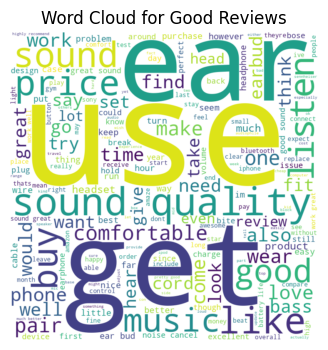

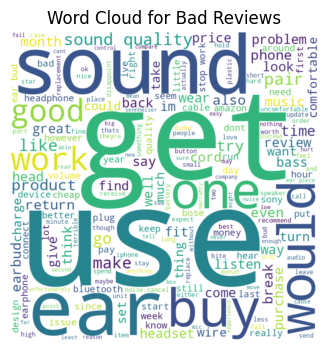

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.add('headphones')

# Create separate text for good and bad reviews
good_reviews_text = ' '.join(merged_df[merged_df['overall'] >= 3]['reviewText'])
bad_reviews_text = ' '.join(merged_df[merged_df['overall'] < 3]['reviewText'])

# Generate Word Clouds
good_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,  # Use the modified stop words list
                min_font_size = 10).generate(good_reviews_text)

bad_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,  # Use the modified stop words list
                min_font_size = 10).generate(bad_reviews_text)

# Plot Word Clouds for Good Reviews
plt.figure(figsize = (4, 4))
plt.imshow(good_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Good Reviews')
plt.show()

# Plot Word Clouds for Bad Reviews
plt.figure(figsize = (4, 4))
plt.imshow(bad_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Bad Reviews')
plt.show()

In [ ]:
# Tokenize the good and bad reviews
good_tokens = [word.lower() for word in word_tokenize(good_reviews_text) if word.lower() not in stop_words and len(word) > 1]
bad_tokens = [word.lower() for word in word_tokenize(bad_reviews_text) if word.lower() not in stop_words and len(word) > 1]

# Count the occurrences of each word
good_word_counts = Counter(good_tokens)
bad_word_counts = Counter(bad_tokens)

# Print the top 10 most common words in good reviews
print("Top 10 most common words in good reviews:")
print(good_word_counts.most_common(10))

# Print the top 10 most common words in bad reviews
print("\nTop 10 most common words in bad reviews:")
print(bad_word_counts.most_common(10))

Top 10 most common words in good reviews:
[('sound', 148101), ('use', 84426), ('good', 79562), ('great', 76067), ('quality', 60202), ('get', 56223), ('like', 54342), ('ear', 51326), ('work', 50494), ('price', 44565)]

Top 10 most common words in bad reviews:
[('sound', 20901), ('use', 12547), ('work', 11370), ('get', 10706), ('ear', 9725), ('quality', 9195), ('good', 8478), ('like', 7789), ('pair', 7500), ('buy', 7433)]


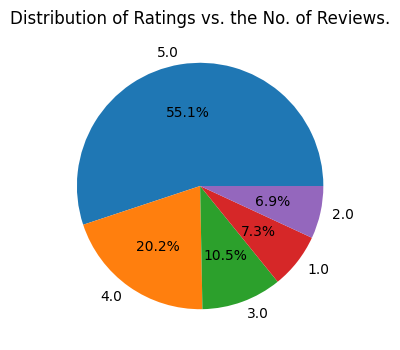

In [ ]:
overalls_distribution = merged_df['overall'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(overalls_distribution, labels=overalls_distribution.index, autopct='%1.1f%%')
plt.title('Distribution of overalls vs. the No. of Reviews.')
plt.show()

In [ ]:
year_with_max_reviews = merged_df['year'].value_counts().idxmax()
print("Year with maximum reviews:", year_with_max_reviews)

Year with maximum reviews: 2016


In [ ]:
# assuming each reviewer is a customer
year_with_highest_customers = merged_df.groupby('year')['reviewerID'].nunique().idxmax()
print("Year with the highest number of customers:", year_with_highest_customers)

Year with the highest number of customers: 2016


## Feature Extraction from Review Text

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,  # Limit the number of features to 5000
                                   stop_words='english',  # Remove common English stopwords
                                   lowercase=True,  # Convert text to lowercase
                                   ngram_range=(1, 1))  # Consider unigrams (single words)

tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['reviewText'])

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (1878, 5000)


In [ ]:
pickle_file_path = 'tfidf_matrix.pickle'

with open(pickle_file_path, 'wb') as f:
    pickle.dump(tfidf_matrix, f)

In [ ]:
def classify_overall(overall):
    if overall > 3:
        return 'Good'
    elif overall == 3:
        return 'Average'
    else:
        return 'Bad'

merged_df['overall_class'] = merged_df['overall'].apply(classify_overall)

print(merged_df[['overall', 'overall_class']])

      overall rating_class
0         5.0         Good
1         5.0         Good
2         5.0         Good
3         5.0         Good
4         3.0      Average
...       ...          ...
1873      5.0         Good
1874      5.0         Good
1875      5.0         Good
1876      4.0         Good
1877      5.0         Good

[1878 rows x 2 columns]


In [ ]:
merged_df.to_pickle('merged_df.pickle')

In [ ]:
from sklearn.model_selection import train_test_split

X = merged_df['reviewText']
y = merged_df['overall_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Train data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (1408,) (1408,)
Test data shape: (470,) (470,)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', lowercase=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": MultinomialNB()
}

for name, model in models.items():
    print("Training", name)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print("Classification Report for", name)
    print(classification_report(y_test, y_pred))

## Collaborative Filtering

In [121]:
duplicate_entries = merged_df[merged_df.duplicated(['reviewerID'], keep=False)]
print("Duplicate Entries:")
print(duplicate_entries)

Duplicate Entries:
        overall vote  verified   reviewTime      reviewerID        asin  \
0           5.0    2      True  02 28, 2013  A15U5NUS1EY7IQ  B000001OMI   
2           5.0    4      True  11 27, 2008   A680RUE1FDO8B  B000001OMI   
6           5.0  NaN      True   06 7, 2017  A168AALR3BOYR7  B000001OMI   
15          3.0  NaN      True  07 16, 2015  A2PGU700RITDMT  B000001OMI   
16          5.0  NaN      True   02 8, 2015   AQJG2NIMJFQ2E  B000001OMI   
...         ...  ...       ...          ...             ...         ...   
172665      5.0  NaN      True  09 24, 2018   AHV4HWN6340HT  B01HDUTJC4   
172669      3.0  NaN      True  09 28, 2018   A5YSRCFY4MEB8  B01HETFQA8   
172670      4.0  NaN     False  05 21, 2017   AD0XPDO2S2UV8  B01HG3CZJW   
172672      5.0  NaN      True  07 21, 2018  A3FA3EXAUOYJZQ  B01HHUFQOA   
172673      4.0  NaN      True  07 19, 2018  A2EMPOLSFD2EVJ  B01HHUFQOA   

                                     style      reviewerName  \
0       {'Format

In [134]:
merged_df[merged_df['reviewerID'] == 'A15U5NUS1EY7IQ']

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,...,feature,rank,also_view,main_cat,similar_item,date,price,imageURL,imageURLHighRes,details
0,5.0,2,True,"02 28, 2013",A15U5NUS1EY7IQ,B000001OMI,{'Format:': ' Personal Computers'},S. Bommarito,im get listen station go in several elementary...,Works well,...,"[Lightweight, Open-air Headphones, Ideal For A...","[>#53,588 in Cell Phones & Accessories (See To...",[],Home Audio & Theater,"class=""a-bordered a-horizontal-stripes a-spa...","September 4, 1973",$6.55,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
4416,5.0,NaN,True,"03 24, 2013",A15U5NUS1EY7IQ,B00004T8R2,{'Style:': ' On Ear'},S. Bommarito,using these for a listen station at an element...,Using at a school.,...,"[Wired On-Ear Headphones: Lightweight, open-ai...",[>#824 in Cell Phones &amp; Accessories (See T...,[],Home Audio &amp; Theater,"class=""a-bordered a-horizontal-stripes a-spa...","October 6, 2017",$7.99,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
8894,5.0,NaN,True,"02 28, 2013",A15U5NUS1EY7IQ,B00008Z1PT,{'Product Packaging:': ' Standard Packaging'},S. Bommarito,im get listen station go in several elementary...,Another good one,...,"[Open-Air Type, Super lightweight comfortable ...","[>#373,006 in Cell Phones &amp; Accessories (S...","[B00004T8R2, B006T9ZKAQ, B01C35JM08, B0002D071...",Home Audio &amp; Theater,"class=""a-bordered a-horizontal-stripes a-spa...","April 2, 2008",,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
18730,5.0,NaN,True,"02 28, 2013",A15U5NUS1EY7IQ,B000IK4C24,{'Product Packaging:': ' Standard Packaging'},S. Bommarito,im get listen station go in several elementary...,Another good one,...,"[Open-air type, Powerful 40mm drivers deliver ...","[>#547,964 in Cell Phones & Accessories (See T...","[B00004T8R2, B006T9ZKAQ, B004HIN9WC, B01C35JM0...",Home Audio & Theater,"class=""a-bordered a-horizontal-stripes a-spa...","June 23, 2006",,[],[],{}


In [122]:
subset_df = duplicate_entries.sample(n=1000, random_state=70)

users = subset_df['reviewerID'].unique().tolist()
items = subset_df['asin'].unique().tolist()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

n_values = [10, 20, 30, 40, 50]
mae_per_n = []

In [128]:
print(len(users))
print(len(items))

981
527


In [67]:
# Function to calculate cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = sqrt(np.sum(vec1 ** 2))
    norm2 = sqrt(np.sum(vec2 ** 2))
    return dot_product / (norm1 * norm2)

# Normalize ratings using min-max scaling
def min_max_scaling(ratings):
    min_rating = ratings.min()
    max_rating = ratings.max()
    normalized_ratings = (ratings - min_rating) / (max_rating - min_rating)
    return normalized_ratings

def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))

### User-User Recommender System

In [131]:
def create_rating_matrix(df):
    rating_matrix = np.zeros((len(users), len(items)))
    for user_id, item_id, rating in zip(df['reviewerID'], df['asin'], df['overall']):
        user_idx = users.index(user_id) if user_id in users else -1
        item_idx = items.index(item_id) if item_id in items else -1
        if user_idx != -1 and item_idx != -1:
            rating_matrix[user_idx, item_idx] = rating
    return rating_matrix

In [132]:
def predict_ratings_with_neighbors(n, user_similarity_matrix, rating_matrix):
    neighbors = np.argsort(-user_similarity_matrix, axis=1)[:, :n]
    predicted_ratings = np.copy(rating_matrix)

    for i, user in enumerate(users):
        for j, item in enumerate(items):
            if rating_matrix[i, j] == 0:
                neighbor_indices = neighbors[i]
                neighbor_ratings = [rating_matrix[neighbor, j] for neighbor in neighbor_indices if rating_matrix[neighbor, j] != 0]
                if neighbor_ratings:
                    predicted_ratings[i, j] = np.mean(neighbor_ratings)

    return predicted_ratings

In [133]:
for n in n_values:
    mae_values = []
    for train_index, val_index in kf.split(subset_df):
        train_df = subset_df.iloc[train_index]
        val_df = subset_df.iloc[val_index]

        rating_matrix = create_rating_matrix(train_df)
        normalized_ratings = min_max_scaling(rating_matrix)

        user_similarity_matrix = np.zeros((len(users), len(users)))
        for i in range(len(users)):
            for j in range(len(users)):
                user_similarity_matrix[i, j] = cosine_similarity(normalized_ratings[i], normalized_ratings[j])

        predicted_ratings = predict_ratings_with_neighbors(n, user_similarity_matrix, rating_matrix)
        val_rating_matrix = create_rating_matrix(val_df)

        idx = [val_rating_matrix != 0]
        print(len(idx))

        mae = mean_absolute_error(val_rating_matrix[val_rating_matrix != 0], predicted_ratings[val_rating_matrix != 0])
        mae_values.append(mae)

    print(f"Mean Absolute Error for {n} nearest neighbors: {np.mean(mae_values):.3f}")
    mae_per_n.append(np.mean(mae_values))

<ipython-input-67-3df7a5474b30>:6: RuntimeWarning: invalid value encountered in scalar divide
  return dot_product / (norm1 * norm2)


1
1
1
1
1
Mean Absolute Error for 10 nearest neighbors: 3.922
1
1
1
1
1
Mean Absolute Error for 20 nearest neighbors: 3.896
1
1
1
1
1
Mean Absolute Error for 30 nearest neighbors: 3.666
1
1
1
1
1
Mean Absolute Error for 40 nearest neighbors: 3.589
1
1
1
1
1
Mean Absolute Error for 50 nearest neighbors: 3.507


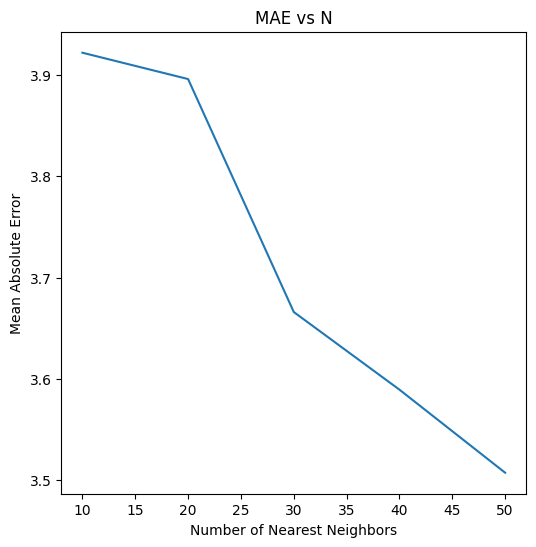

In [135]:
plt.figure(figsize=(6, 6))
plt.plot(n_values, mae_per_n)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs N')
plt.show()

### Item-Item Recommender System

In [137]:
def create_rating_matrix(df):
    rating_matrix = np.zeros((len(items), len(users)))
    for item_id, user_id, rating in zip(df['asin'], df['reviewerID'], df['overall']):
        item_idx = items.index(item_id) if item_id in items else -1
        user_idx = users.index(user_id) if user_id in users else -1
        if item_idx != -1 and user_idx != -1:
            rating_matrix[item_idx, user_idx] = rating
    return rating_matrix

In [138]:
def predict_ratings_with_neighbors(n, item_similarity_matrix, rating_matrix):
    neighbors = np.argsort(-item_similarity_matrix, axis=1)[:, :n]
    predicted_ratings = np.copy(rating_matrix)

    for i in range(len(items)):
        for j in range(len(users)):
            if rating_matrix[i, j] == 0:
                neighbor_indices = neighbors[i]
                neighbor_ratings = [rating_matrix[neighbor, j] for neighbor in neighbor_indices if rating_matrix[neighbor, j] != 0]
                if neighbor_ratings:
                    predicted_ratings[i, j] = np.mean(neighbor_ratings)

    return predicted_ratings

In [139]:
mae_per_n_2 = []

In [ ]:
for n in n_values:
    mae_values = []
    for train_index, val_index in kf.split(subset_df):
        train_df = subset_df.iloc[train_index]
        val_df = subset_df.iloc[val_index]

        rating_matrix = create_rating_matrix(train_df)
        normalized_ratings = min_max_scaling(rating_matrix)

        item_similarity_matrix = np.zeros((len(items), len(items)))
        for i in range(len(items)):
            for j in range(len(items)):
                item_similarity_matrix[i, j] = cosine_similarity(normalized_ratings[i], normalized_ratings[j])

        predicted_ratings = predict_ratings_with_neighbors(n, item_similarity_matrix, rating_matrix)
        val_rating_matrix = create_rating_matrix(val_df)

        idx = [val_rating_matrix != 0]
        print(len(idx))

        mae = mean_absolute_error(val_rating_matrix[val_rating_matrix != 0], predicted_ratings[val_rating_matrix != 0])
        mae_values.append(mae)

    print(f"Mean Absolute Error for {n} nearest neighbors: {np.mean(mae_values):.5f}")
    mae_per_n_2.append(np.mean(mae_values))

<ipython-input-67-3df7a5474b30>:6: RuntimeWarning: invalid value encountered in scalar divide
  return dot_product / (norm1 * norm2)


1
1
1
1
1
Mean Absolute Error for 10 nearest neighbors: 4.04300
1
1
1
1
1
Mean Absolute Error for 20 nearest neighbors: 4.04300
1
1
1
1
1
Mean Absolute Error for 30 nearest neighbors: 4.04300
1
1
1
1
1
Mean Absolute Error for 40 nearest neighbors: 4.04300
1


In [130]:
idx = [val_rating_matrix != 0]
print(len(idx))

1


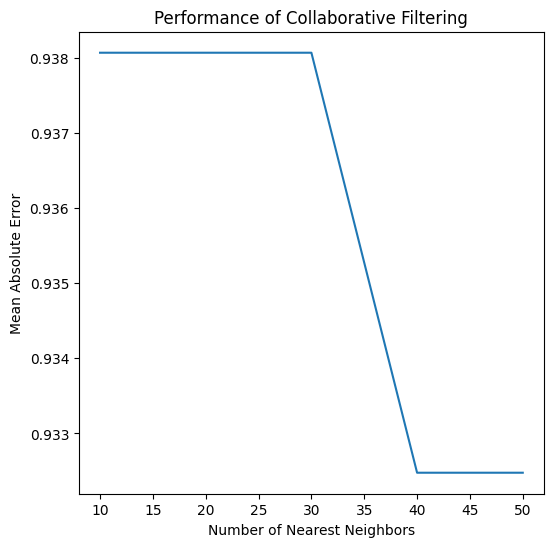

In [101]:
plt.figure(figsize=(6, 6))
plt.plot(n_values, mae_per_n_2)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Mean Absolute Error')
plt.title('Performance of Collaborative Filtering')
plt.show()

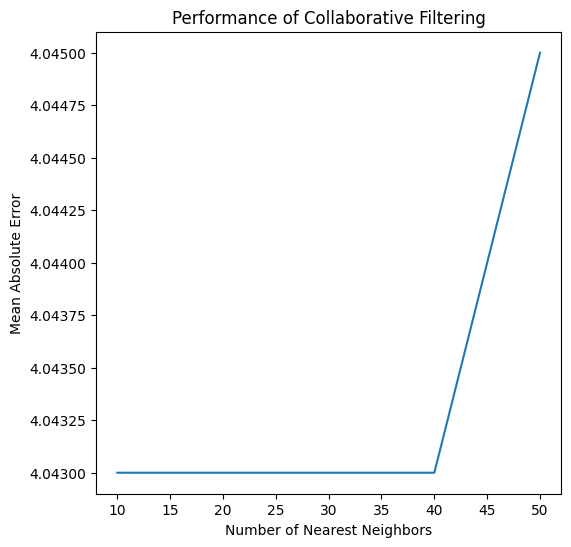

In [129]:
plt.figure(figsize=(6, 6))
plt.plot(n_values, mae_per_n_2)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Mean Absolute Error')
plt.title('Performance of Collaborative Filtering')
plt.show()

## Top 10 Products by User Sum Ratings

In [ ]:
product_sum_ratings = merged_df.groupby('title')['overall'].sum()

top_10_products = product_sum_ratings.sort_values(ascending=False).head(10)

print("Top 10 products by user sum ratings:")
print(top_10_products)